In [41]:
import torch 
import pypose as pp
import h5py
import kornia

from perseus.smoother.base_v2 import FixedLagSmoother, RigidBodyTrajectory, SmootherConfig
from perseus.smoother.utils import *
from perseus.detector.models import KeypointCNN
from functools import partial
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
# Load model 
model = KeypointCNN()
model.load_state_dict(torch.load("outputs/models/fbz72ad3.pth"))
model.eval()

# Load data
dataset = h5py.File("data/2024-01-12_17-21-39/mjc_data.hdf5")

In [768]:
# Create smoother.
dt = 1 / 30.
horizon = 15
dynamics = partial(zero_acc_euler_dynamics, dt=dt)
keypoint_cfg = get_keypoint_config_from_dataset("data/2024-01-12_17-21-39/0036634d-f287-412d-a054-916f2b7566cf")
measurement = partial(keypoint_measurement, cfg=keypoint_cfg)
smoother_cfg = SmootherConfig(horizon=horizon)

smoother = FixedLagSmoother(smoother_cfg, dynamics, measurement)

In [777]:
# Test smoother on one run.
split = "test"
traj_idx = 222
images = kornia.utils.image_to_tensor(dataset[split]["images"][traj_idx]) / 255.
gt_keypoints = torch.tensor(dataset[split]["pixel_coordinates"][traj_idx])
object_poses = pp.SE3(dataset[split]["object_poses"][traj_idx])
camera_poses = pp.SE3(dataset[split]["camera_poses"][traj_idx])
keypoint_cfg = get_keypoint_config_from_dataset(Path(dataset[split]["image_filenames"][traj_idx][0].astype(str)).parent)
measurement = partial(keypoint_measurement, cfg=keypoint_cfg)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(model(images).reshape(-1, 8, 2), *images.shape[2:]).detach()

smoother = FixedLagSmoother(smoother_cfg, dynamics, measurement)
pose_estimates = []

# Initialize smoother.
for tt in range(object_poses.shape[0]):
    if tt > smoother.horizon:
        pose_estimates.append(smoother.trajectory.poses[0].clone())
    print("start: ", smoother.trajectory.poses[0])
    smoother.update(pred_keypoints[tt])
    if tt == smoother.horizon:
        for ii in range(5):
            smoother.step()
    else:
        for ii in range(
                        ):
            smoother.step()

    print("end: ", smoother.trajectory.poses[0])

pose_estimates = torch.stack(pose_estimates)
pose_estimates = torch.cat((pose_estimates, smoother.trajectory.poses))

start:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
end:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
start:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
end:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
start:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
end:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
start:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
end:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
start:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
end:  SE3Type LieTensor:
LieTensor([ 0.,  0., -6.,  0.,  0.,  0.,  1.], grad_fn=<AliasBackward0>)
start:  SE

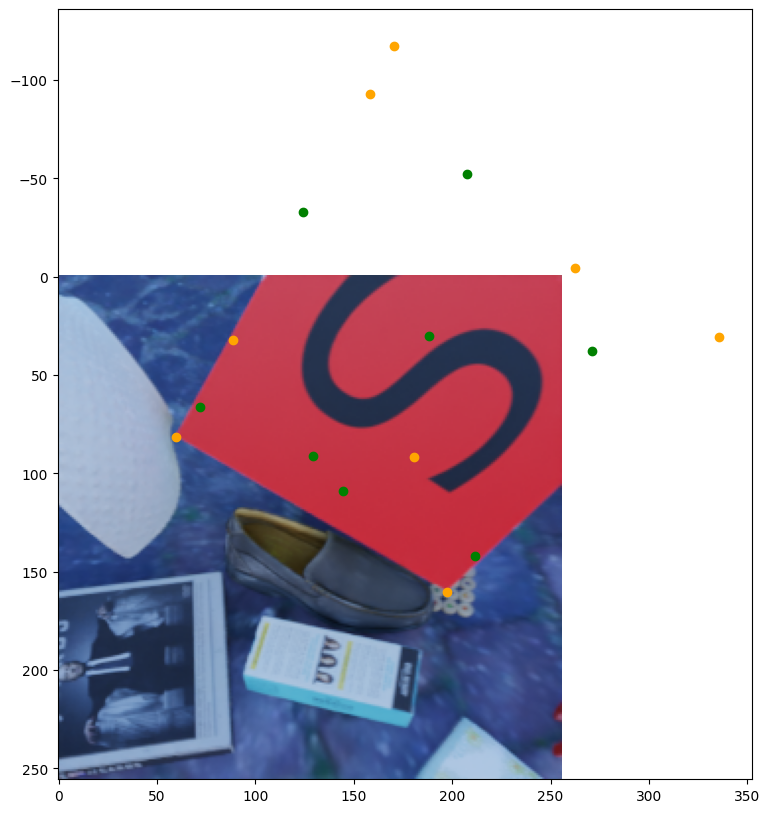

In [781]:
# Visualize predicted keypoints and smoothed trajectory.
import matplotlib.pyplot as plt
image_idx = 1
plt.figure(figsize=(10, 10))
plt.imshow(images[image_idx].permute(1, 2, 0))
# plt.scatter(gt_keypoints[image_idx, :, 0], gt_keypoints[image_idx, :, 1], color="red")
# plt.scatter(pred_keypoints[image_idx, :, 0], pred_keypoints[image_idx, :, 1], color="blue")

# Compute predicted keypoint locations.
smoothed_keypoints = smoother.trajectory.measurement(pose_estimates).detach()
plt.scatter(smoothed_keypoints[image_idx, :, 0], smoothed_keypoints[image_idx, :, 1], color="green")
# Double-check measurement function.
plt.scatter(measurement(camera_poses.Inv() @ object_poses)[image_idx, :, 0], measurement(camera_poses.Inv() @ object_poses)[image_idx, :, 1], color="orange")

In [691]:
pixel_covariances = []
for traj_idx in range(500):
    images = kornia.utils.image_to_tensor(dataset[split]["images"][traj_idx].reshape(-1, 256, 256, 3)) / 255.
    gt_keypoints = torch.tensor(dataset[split]["pixel_coordinates"][traj_idx])
    object_poses = pp.SE3(dataset[split]["object_poses"][traj_idx])
    camera_poses = pp.SE3(dataset[split]["camera_poses"][traj_idx])
    keypoint_cfg = get_keypoint_config_from_dataset(Path(dataset[split]["image_filenames"][traj_idx][0].astype(str)).parent)
    measurement = partial(keypoint_measurement, cfg=keypoint_cfg)
    pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(model(images).reshape(-1, 8, 2), *images.shape[2:]).detach()

    pixel_errors = (gt_keypoints - pred_keypoints).reshape(-1, 2)
    pixel_errors = torch.clamp(pixel_errors, -50, 50)
    pixel_covariances.append(torch.cov(pixel_errors.T))


IndexError: Index (482) out of range for (0-481)

In [694]:
torch.mean(torch.stack(pixel_covariances), dim=0)

tensor([[122.2280,  -1.6218],
        [ -1.6218, 121.0448]])